In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import random
import torch.nn.functional as F
import argparse
from sklearn import metrics
from tqdm.notebook import tqdm
import gc
import shutil 
from torchsummary import summary

In [3]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [4]:
labels = ['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff',
       'Replace', 'BothReleased']

In [5]:
torch.manual_seed(2021)
np.random.seed(2021)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=1, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=512, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.01, help="adam's learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.99, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=1, help="number of cpu threads to use during batch generation")
parser.add_argument("--in_len", type=int, default=2**10, help="length of the input fed to neural net")
parser.add_argument("--in_channels", type=int, default=32, help="number of signal channels")
parser.add_argument("--out_channels", type=int, default=6, help="number of classes")
parser.add_argument("--chunk", type=int, default=1000, help="length of splited chunks")
opt, unknown = parser.parse_known_args()
print(device)

cpu


In [6]:
%%time
def read_csv(data, events):
    x = pd.read_csv(data)
    y = pd.read_csv(events)
    id = '_'.join(x.iloc[0, 0].split('_')[:-1])
    x = x.iloc[:,1:].values
    y = y.iloc[:,1:].values
    return x, y
    

trainset = []
gt = []
for filename in tqdm(os.listdir('/content/drive/MyDrive/EEG data')):
    if 'data' in filename:
        data_file_name = os.path.join('/content/drive/MyDrive/EEG data', filename)
        id = filename.split('.')[0]
        events_file_name = os.path.join('/content/drive/MyDrive/EEG data', '_'.join(id.split('_')[:-1]) + '_events.csv')
        print(data_file_name)
        print(events_file_name)
        x, y = read_csv(data_file_name, events_file_name)
        trainset.append(x.T.astype(np.float32))
        gt.append(y.T.astype(np.float32))

  0%|          | 0/16 [00:00<?, ?it/s]

/content/drive/MyDrive/EEG data/subj1_series1_data.csv
/content/drive/MyDrive/EEG data/subj1_series1_events.csv
/content/drive/MyDrive/EEG data/subj1_series2_data.csv
/content/drive/MyDrive/EEG data/subj1_series2_events.csv
/content/drive/MyDrive/EEG data/subj1_series3_data.csv
/content/drive/MyDrive/EEG data/subj1_series3_events.csv
/content/drive/MyDrive/EEG data/subj1_series4_data.csv
/content/drive/MyDrive/EEG data/subj1_series4_events.csv
/content/drive/MyDrive/EEG data/subj1_series5_data.csv
/content/drive/MyDrive/EEG data/subj1_series5_events.csv
/content/drive/MyDrive/EEG data/subj1_series6_data.csv
/content/drive/MyDrive/EEG data/subj1_series6_events.csv
/content/drive/MyDrive/EEG data/subj1_series7_data.csv
/content/drive/MyDrive/EEG data/subj1_series7_events.csv
/content/drive/MyDrive/EEG data/subj1_series8_data.csv
/content/drive/MyDrive/EEG data/subj1_series8_events.csv
CPU times: user 8.75 s, sys: 917 ms, total: 9.67 s
Wall time: 15.5 s


In [7]:
for dt in trainset:
  mean = np.mean(dt,axis=1)
  std = np.std(dt,axis=1)
  dt = np.transpose(dt)
  dt -= mean
  dt /= std+1e-7
  dt = np.transpose(dt)
  print(dt.shape)

(32, 119496)
(32, 271954)
(32, 217614)
(32, 116240)
(32, 210644)
(32, 249550)
(32, 119561)
(32, 117333)


In [8]:
valid_dataset = trainset[-2:]
valid_gt = gt[-2:]
trainset = trainset[:-2]
gt = gt[:-2]

In [9]:
def resample_data(gt, chunk_size=opt.chunk):
    """
    split long signals to smaller chunks, discard no-events chunks  
    """
    total_discard_chunks = 0
    mean_val = []
    threshold = 0.01
    index = []
    
    for i in range(len(gt)):
        for j in range(0, gt[i].shape[1], chunk_size):
            mean_val.append(np.mean(gt[i][:, j:min(gt[i].shape[1],j+chunk_size)]))
            if mean_val[-1] < threshold:  # discard chunks with low events time
                total_discard_chunks += 1
            else:
                index.extend([(i, k) for k in range(j, min(gt[i].shape[1],j+chunk_size))])

    plt.plot([0, len(mean_val)], [threshold, threshold], color='r')
    plt.scatter(range(len(mean_val)), mean_val, s=1)
    plt.show()
    print('Total number of chunks discarded: {} chunks'.format(total_discard_chunks))
    print('{}% data'.format(total_discard_chunks/len(mean_val)))
    del mean_val
    gc.collect()
    return index

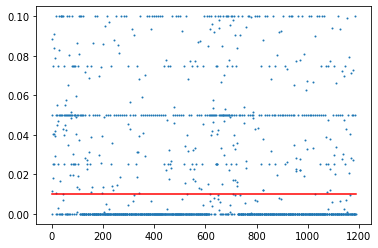

Total number of chunks discarded: 680 chunks
0.5723905723905723% data
508000
CPU times: user 680 ms, sys: 51.5 ms, total: 732 ms
Wall time: 1.01 s


In [10]:
%%time
class EEGSignalDataset(Dataset):
    def __init__(self, data, gt,soft_label=True, train=True):
        self.data = data
        self.gt = gt
        self.train = train
        self.soft_label = soft_label
        self.eps = 1e-7
        if train:
            self.index = resample_data(gt)
        else:
            self.index = [(i, j) for i in range(len(data)) for j in range(data[i].shape[1])]
        
    
    def __getitem__(self, i):
        i, j = self.index[i]
        raw_data, label = self.data[i][:,max(0, j-opt.in_len+1):j+1], \
                self.gt[i][:,j]
        
        pad = opt.in_len - raw_data.shape[1]
        if pad:
            raw_data = np.pad(raw_data, ((0,0),(pad,0)), 'constant',constant_values=0)

        raw_data, label = torch.from_numpy(raw_data.astype(np.float32)),\
                            torch.from_numpy(label.astype(np.float32))
        if self.soft_label:
            label[label < .02] = .02
        return raw_data, label
            
    
    def __len__(self):
        return len(self.index)
    
dataset = EEGSignalDataset(trainset, gt) 
dataloader = DataLoader(dataset, batch_size = opt.batch_size,\
                                       num_workers = opt.n_cpu, shuffle=True)
print(len(dataset))

In [11]:
class NNet1(nn.Module):   # no overlap
    def __init__(self, in_channels=opt.in_channels, out_channels=opt.out_channels):
        super(NNet1, self).__init__()
        self.hidden = 32
        self.net = nn.Sequential(
          
            nn.Conv1d(in_channels, 2*in_channels, 16, stride=16), 
            nn.LeakyReLU(0.1),
            nn.Conv1d(2*in_channels, 4*in_channels, 16, stride=16), 
            nn.LeakyReLU(0.1),
            nn.Conv1d(4*in_channels, out_channels, 4), 
            nn.Sigmoid()
            
        )
    
    def forward(self, x):
        return self.net(x)

In [12]:
class NNet2(nn.Module):   # 25% overlap
    def __init__(self, in_channels=opt.in_channels, out_channels=opt.out_channels):
        super(NNet2, self).__init__()
        self.hidden = 32
        self.net = nn.Sequential(
          
            nn.Conv1d(in_channels, 2*in_channels, 16, stride=12, padding=6), 
            nn.LeakyReLU(0.1),
            nn.Conv1d(2*in_channels, 4*in_channels, 16, stride=12, padding=1), 
            nn.LeakyReLU(0.1),
            nn.Conv1d(4*in_channels, out_channels, 7),
            nn.Sigmoid()
            
        )
    
    def forward(self, x):
        return self.net(x)

In [13]:
class NNet3(nn.Module):   # 50% overlap
    def __init__(self, in_channels=opt.in_channels, out_channels=opt.out_channels):
        super(NNet3, self).__init__()
        self.hidden = 32
        self.net = nn.Sequential(
          
            nn.Conv1d(in_channels, 2*in_channels, 16, stride=8, padding=4), 
            nn.LeakyReLU(0.1),
            nn.Conv1d(2*in_channels, 4*in_channels, 16, stride=8, padding=4), 
            nn.LeakyReLU(0.1),
            nn.Conv1d(4*in_channels, out_channels, 16),
            nn.Sigmoid()
            
        )
    
    def forward(self, x):
        return self.net(x)

In [14]:
class NNet4(nn.Module):   # 75% overlap
    def __init__(self, in_channels=opt.in_channels, out_channels=opt.out_channels):
        super(NNet4, self).__init__()
        self.hidden = 32
        self.net = nn.Sequential(
          
            nn.Conv1d(in_channels, 2*in_channels, 16, stride=4, padding=6), 
            nn.LeakyReLU(0.1),
            nn.Conv1d(2*in_channels, 4*in_channels, 16, stride=4, padding=6), 
            nn.LeakyReLU(0.1),
            nn.Conv1d(4*in_channels, out_channels, 64),
            nn.Sigmoid()
            
        )
    
    def forward(self, x):
        return self.net(x)

In [15]:
class NNet5(nn.Module):   # 75% overlap
    def __init__(self, in_channels=opt.in_channels, out_channels=opt.out_channels):
        super(NNet4, self).__init__()
        self.hidden = 32
        self.net = nn.Sequential(
          
            nn.Conv1d(in_channels, 2*in_channels, 8, padding=3), 
            nn.LeakyReLU(0.1),
            nn.MaxPool1d(4, 4),

            nn.Conv1d(2*in_channels, 4*in_channels, 8, padding=3), 
            nn.LeakyReLU(0.1),
            nn.MaxPool1d(4, 4),

            nn.Conv1d(4*in_channels, out_channels, 4),
            nn.Sigmoid()

        )
    
    def forward(self, x):
        return self.net(x)

In [16]:
class NNet_(nn.Module):
    def __init__(self, in_channels=opt.in_channels, out_channels=opt.out_channels):
        super(NNet_, self).__init__()
        self.hidden = 32
        self.net = nn.Sequential(
            nn.Conv1d(opt.in_channels, opt.in_channels, 5, padding=2),   #32*N
            nn.Conv1d(self.hidden, self.hidden, 16, stride=16),  #32*N
            nn.LeakyReLU(0.1),
            nn.Conv1d(self.hidden, self.hidden, 7, padding=3),
        )
        for i in range(6):
            self.net.add_module('conv{}'.format(i), \
                                self.__block(self.hidden, self.hidden))
        self.net.add_module('final', nn.Sequential(
            nn.Conv1d(self.hidden, out_channels, 1),
            nn.Sigmoid()
        ))
        
    def __block(self, inchannels, outchannels):
        return nn.Sequential(
            nn.MaxPool1d(2, 2),
            nn.Dropout(p=0.1, inplace=True),
            nn.Conv1d(inchannels, outchannels, 5, padding=2),
            nn.LeakyReLU(0.1),
            nn.Conv1d(outchannels, outchannels, 5, padding=2),
            nn.LeakyReLU(0.1),
        )
    
    def forward(self, x):
        return self.net(x)

# Train

In [17]:
nnet = NNet3()
nnet.to(device)
loss_fnc = nn.BCELoss()
adam = optim.Adam(nnet.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
loss_his, train_loss = [], []
nnet.train()
for epoch in range(opt.n_epochs):
    p_bar = tqdm(dataloader)
    for i, (x, y) in enumerate(p_bar):
        x, y = x.to(device), y.to(device)
        pred = nnet(x)
        loss = loss_fnc(pred.squeeze(dim=-1), y) # pred size [1024, 6, 1], need to squeeze the last axis to compare with y
        adam.zero_grad()
        loss.backward()
        adam.step()
        train_loss.append(loss.item())
        p_bar.set_description('[Loss: {}]'.format(train_loss[-1]))
        if i % 50 == 0:
            loss_his.append(np.mean(train_loss))
            train_loss.clear()
    print('[Epoch {}/{}] [Loss: {}]'.format(epoch+1, opt.n_epochs, loss_his[-1]))
    
torch.save(nnet.state_dict(), 'model.pt')

  0%|          | 0/993 [00:00<?, ?it/s]

[Epoch 1/1] [Loss: 31.122029848098755]


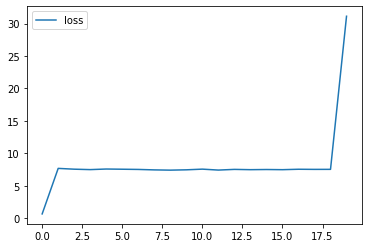

In [18]:
plt.plot(range(len(loss_his)), loss_his, label='loss')
plt.legend()
plt.show()

# Test on validset

In [19]:
testset = EEGSignalDataset(valid_dataset, valid_gt, train=False, soft_label=False) 
testloader = DataLoader(testset, batch_size = opt.batch_size,\
                                       num_workers = opt.n_cpu, shuffle=False)
nnet.eval()
y_pred = []
with torch.no_grad():
    for x, _ in tqdm(testloader):
        x = x.to(device)
        pred = nnet(x).detach().cpu().numpy()
        y_pred.append(pred)
        

  0%|          | 0/463 [00:00<?, ?it/s]

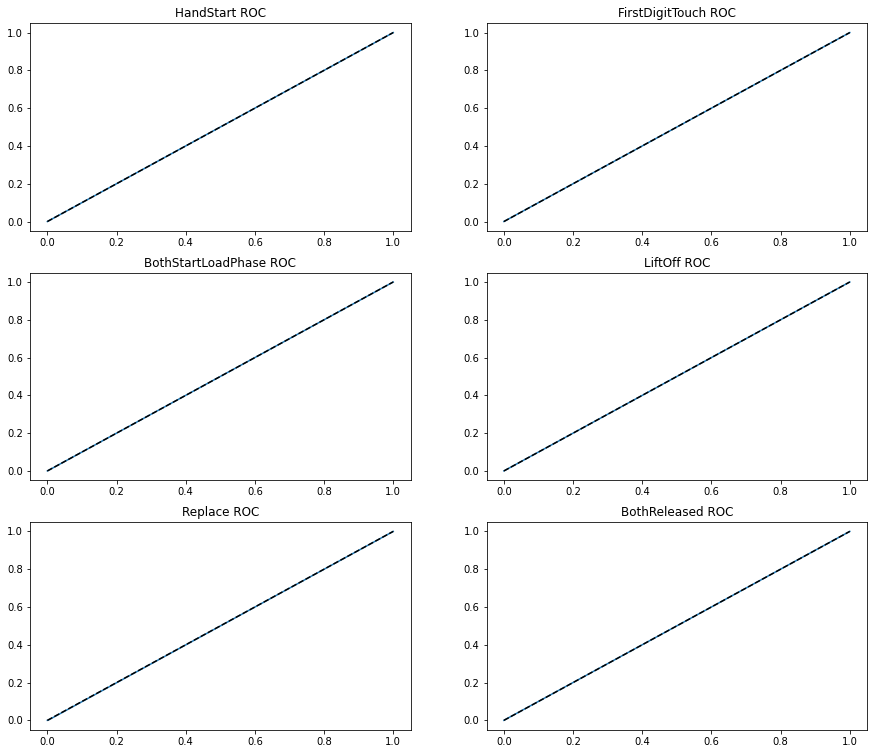

auc roc:  0.49991762433665005
(6, 236894)


In [20]:
def plot_roc(y_true, y_pred):
    fig, axs = plt.subplots(3, 2, figsize=(15,13))
    for i, label in enumerate(labels):
        fpr, tpr, _ = metrics.roc_curve(y_true[i], y_pred[i])
        ax = axs[i//2, i%2]
        ax.plot(fpr, tpr)
        ax.set_title(label+" ROC")
        ax.plot([0, 1], [0, 1], 'k--')
        

    plt.show()
    
y_pred = np.concatenate(y_pred, axis=0).squeeze(axis=-1)
valid_gt = np.concatenate(valid_gt, axis=1)
plot_roc(valid_gt, y_pred.T)
print('auc roc: ', metrics.roc_auc_score(valid_gt.T, y_pred))
print(valid_gt.shape)

In [21]:
for i in range(6):
  print(metrics.roc_auc_score(valid_gt[i], y_pred.T[i]))


0.5
0.5
0.5
0.5
0.49934493193467844
0.5001608140852218


In [22]:
del y_pred
del testset
del testloader
del valid_dataset
del valid_gt
gc.collect()

16689

# Test on trainset

In [ ]:
y_pred = []
y_true = []
with torch.no_grad():
    for x, y in tqdm(dataloader):
        x = x.to(device)
        pred = nnet(x).squeeze(dim=-1).detach().cpu().numpy()
        y_pred.append(pred)
        y_true.append(y)

  0%|          | 0/993 [00:00<?, ?it/s]

In [ ]:
y_pred = np.concatenate(y_pred, axis=0)
y_true = np.concatenate(y_true, axis=0)
y_true[y_true<.1]=0
plot_roc(y_true.T, y_pred.T)
print('auc roc: ', metrics.roc_auc_score(y_true, y_pred))

In [ ]:
i = 1231
with torch.no_grad():
    input = dataset[i][0].unsqueeze(dim=0)
    print(nnet(input.to(device)))
    print(dataset[i][1])

In [ ]:
del y_pred
del y_true
del dataset
del dataloader
del trainset
del gt
gc.collect()